In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
auth = pd.read_csv("../input/banfakenews/Authentic-48K.csv")
fake = pd.read_csv("../input/banfakenews/Fake-1K.csv")

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

In [4]:
!pip install bnltk
!pip install bnlp-toolkit==4.0.0.dev4

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post10-py3-none-any.whl size=2959 sha256=abfd0aa9225dc5aee6b2efb71cee96316c34e8bfb379014ddb8a2bddba88d13c
  Stored in directory: /root/.cache/pip/wheels/5b/f6/92/0173054cc528db7ffe7b0c7652a96c3102aab156a6da960387
Successfully built sklearn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 40.7 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=a2ee7d3756d1fdd72b610c2f060ab544e7c96f8911c943e72f7c45ba817fb7ba
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.8.0
    Uninstalling emoji-2.8.0:


In [5]:
!pip install BnLemma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.9 MB/s eta 0:00:00


In [6]:
df = pd.concat([auth[:fake.shape[0]*7], fake])
df = df.sample(frac=1).reset_index(drop=True)
len(df)

10392

In [7]:
df = df.drop('domain', axis=1)
df = df.drop('date', axis=1)
df = df.drop('category', axis=1)
df = df.drop('articleID', axis=1)

In [8]:
df['data'] = df['headline'] + ' ' + df['content']

In [9]:
df['class'] = df['label'].replace({0: 'fake', 1: 'true'})

In [10]:
df = df.drop('headline', axis=1)
df = df.drop('content', axis=1)
df = df.drop('label', axis=1)




In [11]:
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [12]:
df.dropna(inplace=True)
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [13]:
#for column in df.columns:
#    df[column] = df[column].str.slice(0, 100)

In [14]:
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [15]:
df_lengths = df.applymap(lambda x: len(str(x)))

# Display the DataFrame with string lengths
print(df_lengths)

       data  class
0      1251      4
1      1860      4
2      1266      4
3      1619      4
4      1369      4
...     ...    ...
10387   696      4
10388  1471      4
10389  2667      4
10390  1157      4
10391   758      4

[10392 rows x 2 columns]


In [16]:
#Tokenizer
from bnlp import NLTKTokenizer
bnltk = NLTKTokenizer()

#for Train Set
for i in range(0,df.shape[0]):
    text = bnltk.word_tokenize(df['data'][i])
    df['data'][i] = str(text)


In [17]:
import BnLemma as lm
bl = lm.Lemmatizer()

for i in range(0,df.shape[0]):
    words = str(df['data'][i])
    df['data'][i] = bl.lemma(words)

In [18]:
pip install bangla_stemmer


Note: you may need to restart the kernel to use updated packages.


In [19]:
from bangla_stemmer.stemmer import stemmer

In [20]:
stemr=stemmer.BanglaStemmer()

for i in range(0,df.shape[0]):
    words = str(df['data'][i])
    df['data'][i] = stemr.stem(words)

applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied third rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied third rules..
applied fourth rules..
applied first rules..
applied second rules..
applied third rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied third rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied third rules..
applied fourth rules..
applie

In [21]:
text = df['data'].values.tolist()
label = df['class'].tolist()

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(text , label, test_size=0.2, random_state=42)

In [23]:
pip install ktrain


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 51.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 50.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 43.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 39.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.38.0-py3-none-any.whl size=25319964 sha256=91eae26bc9

In [24]:

import ktrain
from ktrain import text
MODEL_NAME = 'sagorsarker/bangla-bert-base'
t = text.Transformer(MODEL_NAME, maxlen=500)

In [25]:
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_test, y_test)

preprocessing train...
language: bn
train sequence lengths:
	mean : 321
	95percentile : 792
	99percentile : 1378


Is Multi-Label? False
preprocessing test...
language: bn
test sequence lengths:
	mean : 315
	95percentile : 763
	99percentile : 1239


In [26]:
model = t.get_classifier()

In [27]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)


In [28]:
history = learner.fit_onecycle(2e-5, 8)




begin training using onecycle policy with max lr of 2e-05...
Epoch 1/8
1386/1386 [==============================] - 699s 487ms/step - loss: 0.2242 - accuracy: 0.9109 - val_loss: 0.1427 - val_accuracy: 0.9476
Epoch 2/8
1386/1386 [==============================] - 669s 483ms/step - loss: 0.1185 - accuracy: 0.9559 - val_loss: 0.1183 - val_accuracy: 0.9553
Epoch 3/8
1386/1386 [==============================] - 669s 483ms/step - loss: 0.0671 - accuracy: 0.9765 - val_loss: 0.1152 - val_accuracy: 0.9615
Epoch 4/8
1386/1386 [==============================] - 669s 483ms/step - loss: 0.0424 - accuracy: 0.9852 - val_loss: 0.1274 - val_accuracy: 0.9557
Epoch 5/8
1386/1386 [==============================] - 669s 482ms/step - loss: 0.0267 - accuracy: 0.9907 - val_loss: 0.2434 - val_accuracy: 0.9615
Epoch 6/8
1386/1386 [==============================] - 668s 482ms/step - loss: 0.0111 - accuracy: 0.9965 - val_loss: 0.1969 - val_accuracy: 0.9634
Epoch 7/8
1386/1386 [==============================] - 

In [29]:
learner.validate(class_names=t.get_classes()) 


65/65 [==============================] - 47s 669ms/step
              precision    recall  f1-score   support

        fake       0.85      0.85      0.85       266
        true       0.98      0.98      0.98      1813

    accuracy                           0.96      2079
   macro avg       0.91      0.91      0.91      2079
weighted avg       0.96      0.96      0.96      2079



array([[ 226,   40],
       [  41, 1772]])

In [30]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend() 

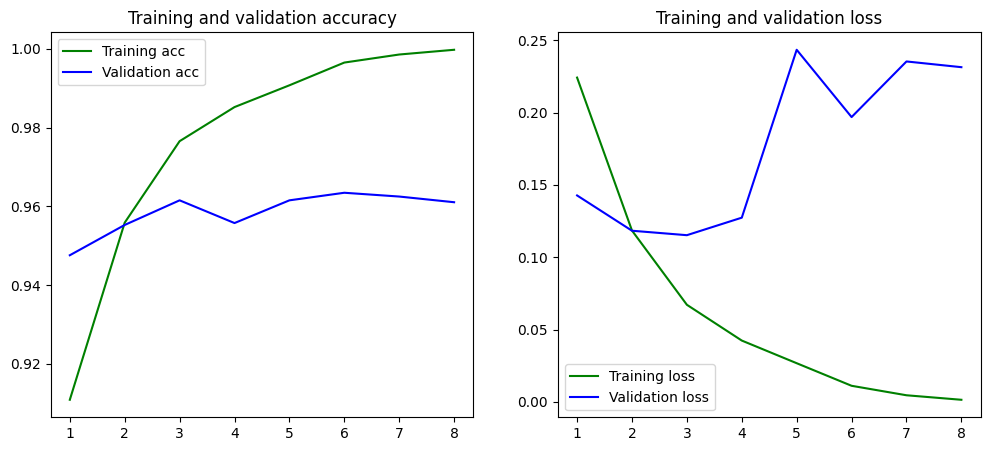

In [31]:
PlotGraph(history)